In [1]:
# Import required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
from keras.callbacks import Callback
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
print ("Number of train files:",len(os.listdir("../input/train")))
print ("Number of test files:",len(os.listdir("../input/test")))

dftrain=pd.read_csv("../input/train_labels.csv",dtype=str)
dftrain.head()

Number of train files: 220025
Number of test files: 57458


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
print("Counts of negative and postive labels in training data:")
dftrain.groupby(['label']).count()

Counts of negative and postive labels in training data:


,id
label,
0,130908
1,89117


In [4]:
def add_ext(id):
    return id+".tif"

dftrain["id"]=dftrain["id"].apply(add_ext)

def addpath(col):
    return '../input/train/' + col 

dftrain['Path']=dftrain['id'].apply(addpath)

dftrain.head()

,id,label,Path
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0,../input/train/f38a6374c348f90b587e046aac60799...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1,../input/train/c18f2d887b7ae4f6742ee445113fa1a...
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0,../input/train/755db6279dae599ebb4d39a9123cce4...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0,../input/train/bc3f0c64fb968ff4a8bd33af6971eca...
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0,../input/train/068aba587a4950175d04c680d38943f...


In [5]:
## function to plot historgrams

def plothist(plot_img,axnum):
    color = ('b','g','r')
    for j,col in enumerate(color):
         histr = cv2.calcHist([plot_img],[j],None,[256],[0,256])
         ax[axnum,i].plot(histr,color = col)
         ax[axnum,i].set_xlim([0,256])
         ax[axnum,i].set_xlabel("Pixel Values")
         ax[axnum,0].set_ylabel("# of Pixels")
    return 

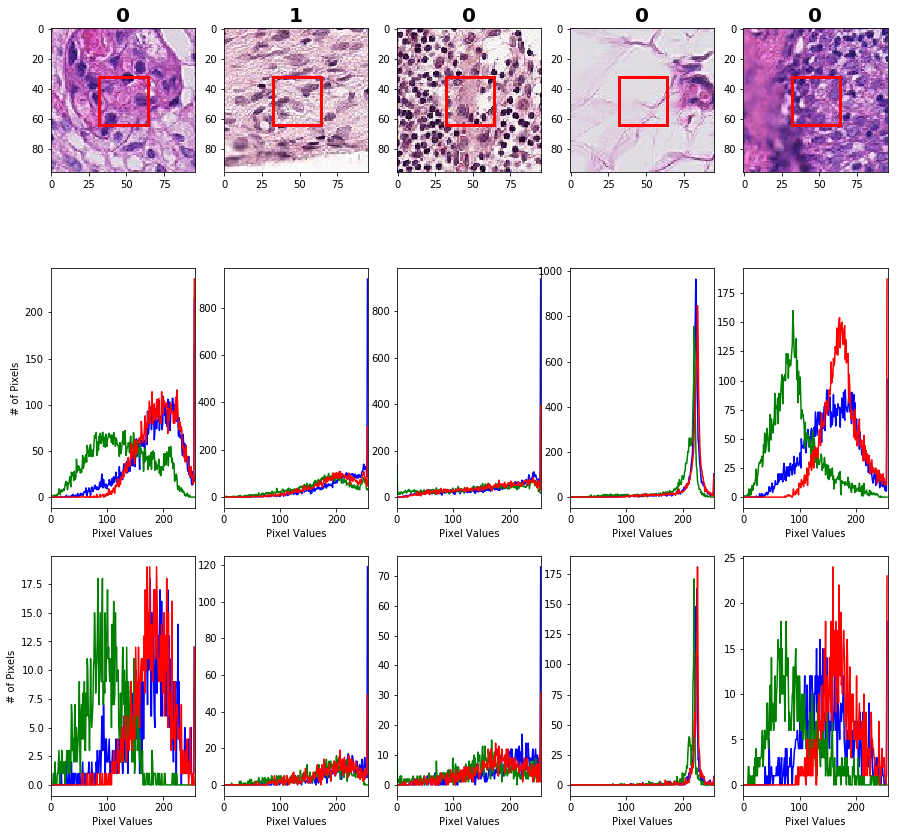

In [6]:
## print a sample of the images
nums = [76, 46, 69, 20, 17] # random.sample(range(1, 100), 5)
num_pics = len(nums)
f,ax = plt.subplots(3,num_pics,figsize=(15,15))

for i in range(5):
    img = plt.imread(dftrain.iloc[nums[i]]['Path'])
   # ax[i].imshow(img)
   # ax[i].set_title(dfdata.iloc[i]['label'],fontweight="bold", size=20)
    ax[0,i].imshow(img)
    ax[0,i].set_title(dftrain.iloc[i]['label'],fontweight="bold", size=20)
    # Create a Rectangle patch
    rect = patches.Rectangle((32,32),32,32,linewidth=3,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax[0,i].add_patch(rect)
    ## plot histograms of full image and cancer patch
    plothist(img,1)
    plothist(img[32:64, 32:64],2)
    
plt.show() 

In [7]:
## use flow from directory

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

In [8]:
batch_size = 20
image_size = (96,96)

train_generator=datagen.flow_from_dataframe(
dataframe=dftrain,
directory="../input/train/",
x_col="id",
y_col="label",
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="binary",
target_size=image_size)

validation_generator=datagen.flow_from_dataframe(
dataframe=dftrain,
directory="../input/train/",
x_col="id",
y_col="label",
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="binary",
target_size=image_size)

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


In [9]:
# build model
input_shape = (96,96,3)
kernel_size = 3

model = Sequential()
model.add(Conv2D(16, (3, 3),input_shape=input_shape)) #input_shape=trainX.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

# layer 2
model.add(Conv2D(32, (3, 3))) #,input_shape=input_shape)) #input_shape=trainX.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3))) #input_shape=trainX.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
                 
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 94, 94, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 45, 45, 32)        0         
__________

model architecture based on:

https://academic.oup.com/bioinformatics/article/32/12/i52/2288769

In [10]:
trainstep=train_generator.n//train_generator.batch_size
valstep=validation_generator.n//validation_generator.batch_size

filepath="weights-best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=trainstep,
                    validation_data=validation_generator,
                    validation_steps=valstep,
                    epochs=10,
                    callbacks=[checkpoint]
)

Epoch 1/10
8801/8801 [==============================] - 450s 51ms/step - loss: 0.6767 - acc: 0.5940 - val_loss: 0.6737 - val_acc: 0.5983

Epoch 00001: val_acc improved from -inf to 0.59830, saving model to weights-best.hdf5
Epoch 2/10
8801/8801 [==============================] - 239s 27ms/step - loss: 0.6756 - acc: 0.5941 - val_loss: 0.6737 - val_acc: 0.5982

Epoch 00002: val_acc did not improve from 0.59830
Epoch 3/10
8801/8801 [==============================] - 238s 27ms/step - loss: 0.6756 - acc: 0.5941 - val_loss: 0.6740 - val_acc: 0.5983

Epoch 00003: val_acc did not improve from 0.59830
Epoch 4/10
8801/8801 [==============================] - 240s 27ms/step - loss: 0.6756 - acc: 0.5941 - val_loss: 0.6738 - val_acc: 0.5980

Epoch 00004: val_acc did not improve from 0.59830
Epoch 5/10
8801/8801 [==============================] - 240s 27ms/step - loss: 0.6756 - acc: 0.5941 - val_loss: 0.6741 - val_acc: 0.5984

Epoch 00005: val_acc improved from 0.59830 to 0.59839, saving model to wei

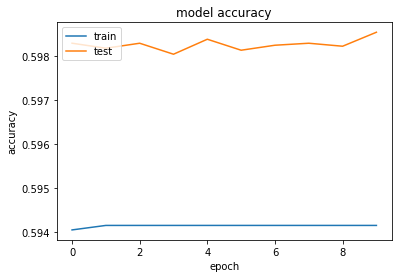

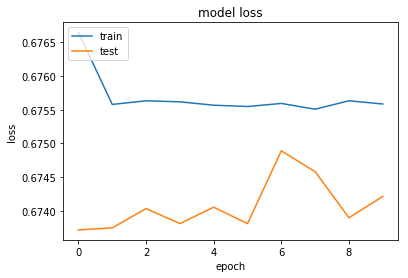

In [11]:
# plot learning curves

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
## evaluate model with validation data



In [12]:
## Create test generator and evaluate model 

model.load_weights(filepath) #load saved weights
test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=datagen.flow_from_dataframe(
dataframe=dftrain,
directory="../input/train/",
x_col="id",
y_col="label",
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="binary",
target_size=image_size)



scores = model.evaluate_generator(test_generator)

print('Test loss:', round(100*scores[0],2))
print('Test accuracy:', round(100*scores[1],2))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Found 44005 images belonging to 2 classes.
Test loss: 67.43
Test accuracy: 59.83
acc: 59.83%


In [21]:
## roc evaluation -- using validation data, this is cheating isn't it?
from sklearn.metrics import roc_curve,auc,confusion_matrix

In [50]:
predictions = model.predict_generator(test_generator, steps=test_generator.n, verbose=1)

44005/44005 [==============================] - 790s 18ms/step


In [56]:
#print(predictions)
type(predictions.tolist())

list

In [68]:
set(predictions[:,0])

{0.41873688}

In [64]:
set(predictions.unravel())

AttributeError: 'numpy.ndarray' object has no attribute 'unravel'

In [62]:
( type(y_prob.argmax(axis=0)))

numpy.ndarray

In [47]:
print(test_generator.classes)

[1 0 0 ... 0 0 0]


In [44]:
print(y_prob)

[[0.41873688]
 [0.41873688]
 [0.41873688]
 ...
 [0.41873688]
 [0.41873688]
 [0.41873688]]


In [42]:
y_prob.unique()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [41]:
print(type(y_prob))

<class 'numpy.ndarray'>


In [27]:
test_labels = test_generator.classes
#y_prob = model.predict_generator(test_generator,verbose=1)
y_pred_keras = y_prob.argmax(axis=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)


In [28]:
print('AUC score :', + auc_keras)

AUC score : 0.5


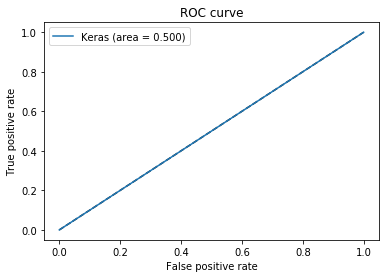

In [18]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

[[26326     0]
 [17679     0]]


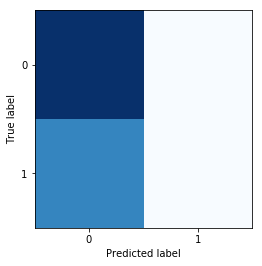

In [22]:
classes=[0,1]
cm=confusion_matrix(test_labels, y_pred_keras)

plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.imshow(cm, cmap=plt.cm.Blues)
print(cm)

In [ ]:
## predictions for submitting

In [76]:
test_list = os.listdir('../input/train')

In [74]:
test_generator = test_datagen.flow_from_directory(
    directory='../input/test',
    target_size=(96,96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


Found 0 images belonging to 0 classes.


In [73]:
preds = model.predict_generator(test_generator, steps=test_generator.n, verbose=1)